<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>
<center><em>Content Copyright by HongLab, Inc.</em></center>

### 비선형 커브 맞추기

- SGD, Adam (배치, 모멘텀 사용)
- 뉴럴 네트워크 구조, 활성화함수에 따른 피팅 결과 차이
- 로스 그래프의 특징 (Non-convex optimization)
- Overfitting vs Underfitting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchviz

torch.manual_seed(2)
np.random.seed(2)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: cpu


In [2]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.n_samples = x_data.shape[0]
    def __len__(self):
        return self.n_samples
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

In [3]:
import altair as alt
import pandas as pd
import kagglehub
path = kagglehub.dataset_download("jayhingrajiya/auto-mpg-dataset-miles-per-gallon")
data = pd.read_csv(path + "/auto.csv")
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
data = data.dropna(subset=['horsepower', 'mpg'])  # Add this line

alt.Chart(data).mark_point().encode(
    # x=alt.X('weight', title='weight'),
    x=alt.X('horsepower', title='horsepower'),
    y=alt.Y('mpg', title='mpg'),
    color='origin',
    tooltip=['horsepower', 'mpg']
).interactive()  # Enables zooming and panning

alt.Chart(...)

In [4]:
x_numpy = data['horsepower'].values.astype(np.float32)
y_numpy = data['mpg'].values.astype(np.float32)

# Normalize data
x_numpy = (x_numpy - x_numpy.mean()) / x_numpy.std()
y_numpy = (y_numpy - y_numpy.mean()) / y_numpy.std()

# Split indices (70% train, 15% val, 15% test)
n_samples = len(x_numpy)
indices = np.random.permutation(n_samples)

train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create tensors for each split
x_train = torch.from_numpy(x_numpy[train_indices]).unsqueeze(1).to(device)
y_train = torch.from_numpy(y_numpy[train_indices]).unsqueeze(1).to(device)

x_val = torch.from_numpy(x_numpy[val_indices]).unsqueeze(1).to(device)
y_val = torch.from_numpy(y_numpy[val_indices]).unsqueeze(1).to(device)

x_test = torch.from_numpy(x_numpy[test_indices]).unsqueeze(1).to(device)
y_test = torch.from_numpy(y_numpy[test_indices]).unsqueeze(1).to(device)

# Create datasets
train_dataset = RegressionDataset(x_train, y_train)
val_dataset = RegressionDataset(x_val, y_val)
test_dataset = RegressionDataset(x_test, y_test)

# Create dataloaders
#batch_size = 32
batch_size = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [5]:
def train(model):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    num_epochs = 10000
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0.0
        for x_inputs, y_targets in train_loader:
            y_pred = model(x_inputs)
            loss = criterion(y_pred, y_targets)
            train_loss += loss.item() * len(x_inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x_inputs, y_targets in val_loader:
                y_pred = model(x_inputs)
                loss = criterion(y_pred, y_targets)
                val_loss += loss.item() * len(x_inputs)
            
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)
        
        # if (epoch + 1) % (num_epochs // 10) == 0:
        #     print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

    # torch.save(model.state_dict(), 'my_model.pth')
    # model.load_state_dict(torch.load('my_model.pth'))
    model.eval()

    # Calculate final losses
    with torch.no_grad():
        test_loss = 0.0
        for x_inputs, y_targets in test_loader:
            y_pred = model(x_inputs)
            loss = criterion(y_pred, y_targets)
            test_loss += loss.item() * len(x_inputs)
        test_loss /= len(test_dataset)

    print(f'Final Test Loss: {test_loss:.4f}')

    train_losses = train_losses[20:] # Loss가 너무 높은 앞부분 삭제
    val_losses = val_losses[20:]

    # Plot training curves and predictions
    plt.figure(figsize=(15, 5))

    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Training data and predictions
    plt.subplot(1, 3, 2)
    plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), color='blue', alpha=0.5, label='Train')
    plt.scatter(x_val.cpu().numpy(), y_val.cpu().numpy(), color='red', alpha=0.5, label='Val')
    plt.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), color='yellow', alpha=0.5, label='Test')

    # Model predictions
    x_line = torch.linspace(torch.min(x_train), torch.max(x_train), 100).unsqueeze(1).to(device)
    y_line = model(x_line).detach().cpu().numpy()
    plt.plot(x_line.cpu().numpy(), y_line, color='black', label='Model')

    plt.title('Predictions vs Data')
    plt.xlabel('Normalized Horsepower')
    plt.ylabel('Normalized MPG')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

주의: 
- 마지막에 Relu를 사용하면 gradient가 0이 될 수도 있음
- Linear()를 여러번 겹쳐 사용하는 것은 결국 Linear()임

Final Test Loss: 0.2728


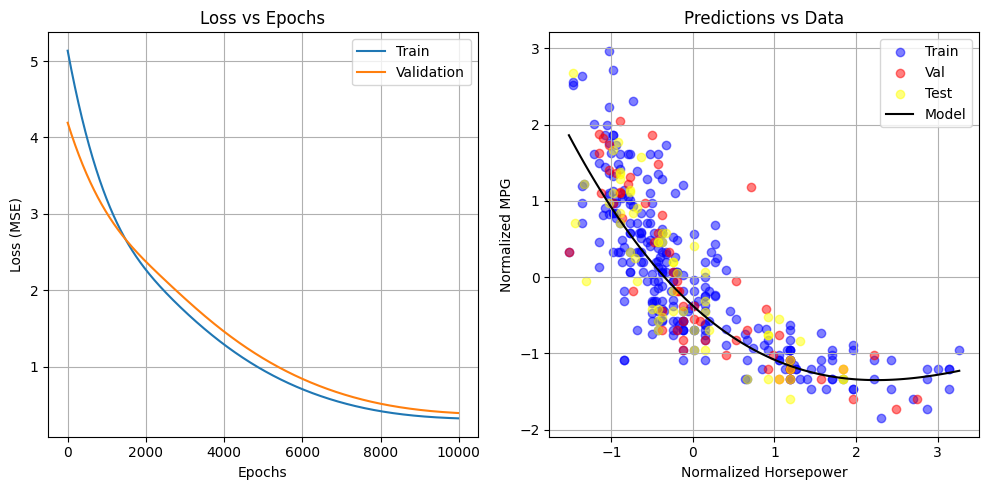

In [6]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Directly define parameters for y = a*x^2 + b*x + c
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))
        self.d = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.a * x**3 + self.b * x**2 + self.c * x + self.d

train(SimpleModel().to(device))

Final Test Loss: 0.7914


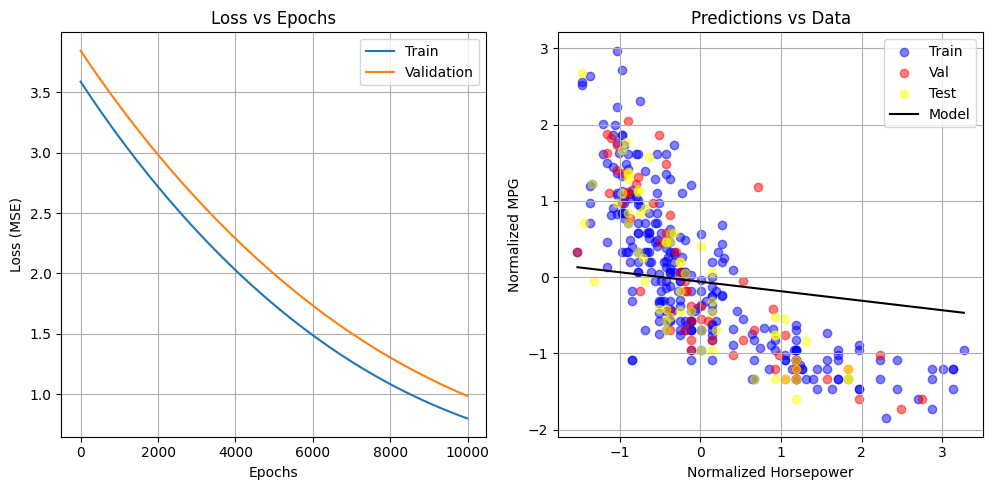

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2706


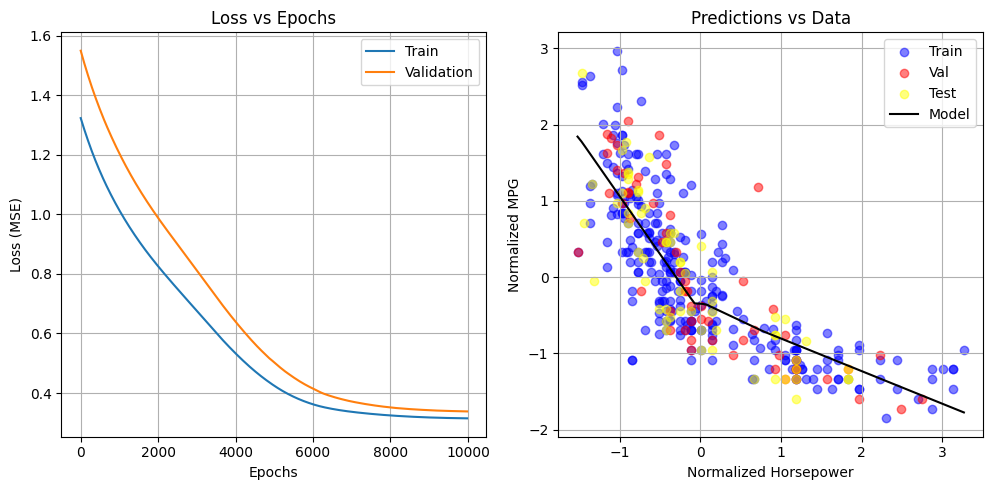

In [8]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=4, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=4, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2578


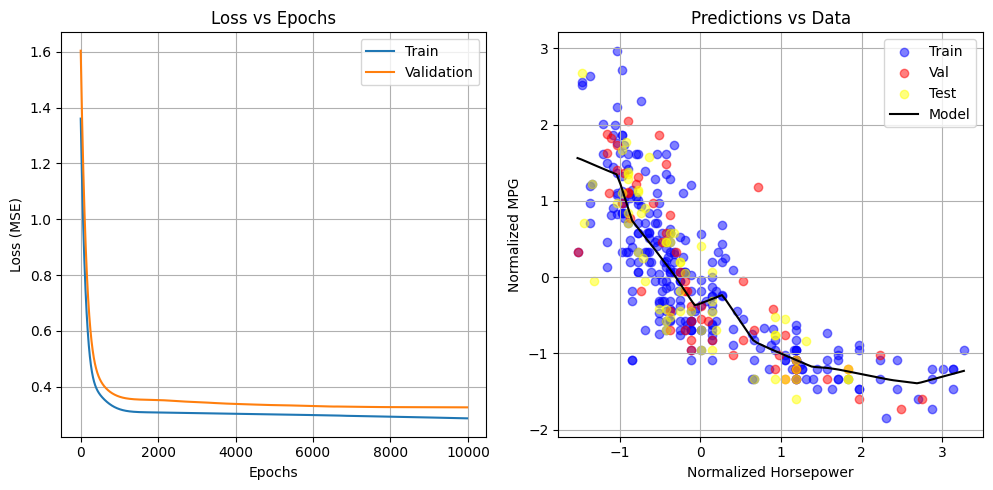

In [9]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=128, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=128, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2622


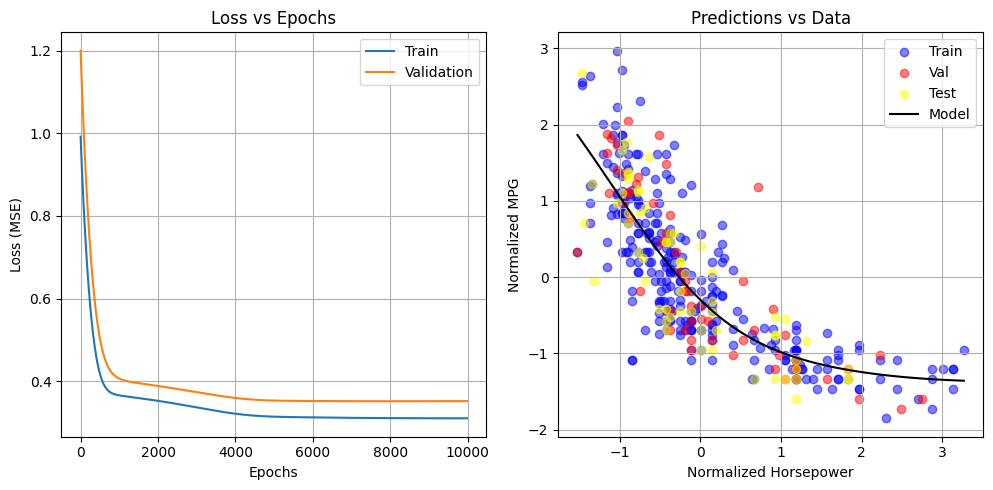

In [10]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=128, bias=True))
        self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(in_features=128, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2599


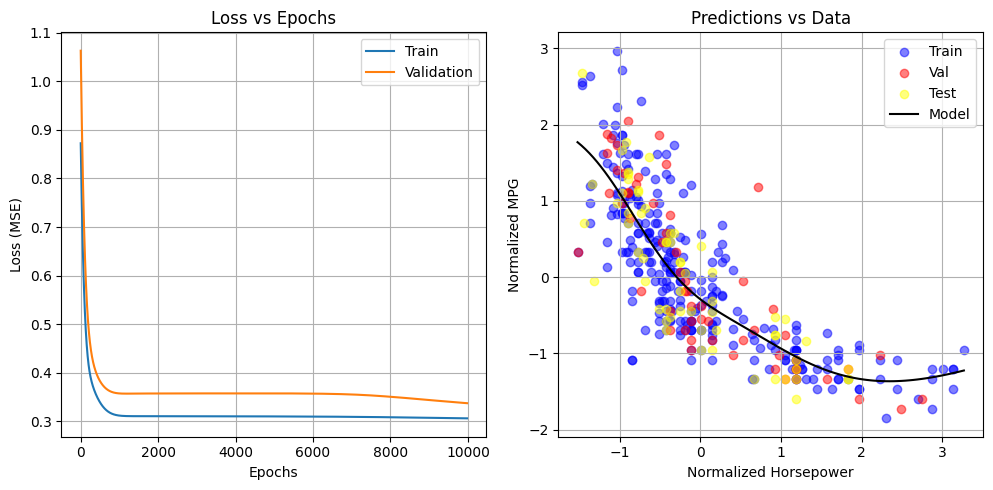

In [11]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=128, bias=True))
        self.layers.append(nn.GELU())
        self.layers.append(nn.Linear(in_features=128, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))

Final Test Loss: 0.2560


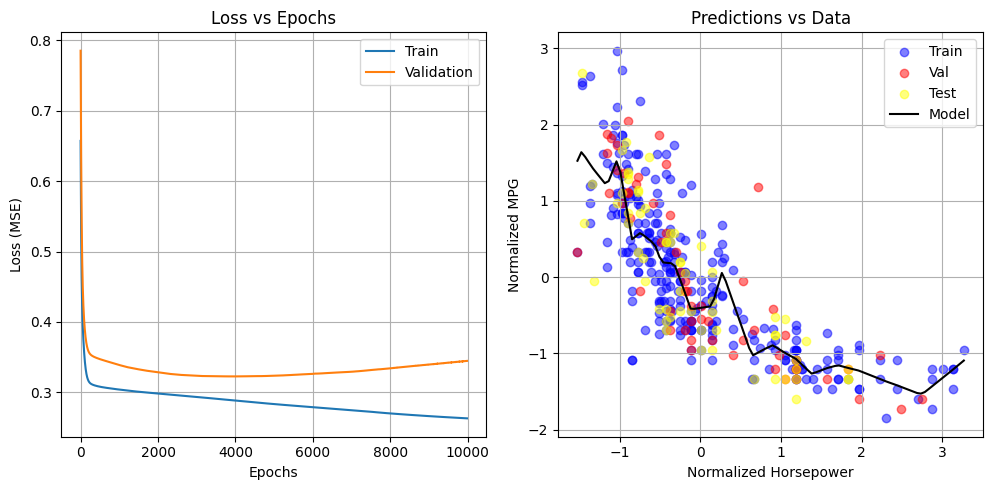

In [12]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features=1, out_features=512, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(in_features=512, out_features=1, bias=True))

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

train(SimpleModel().to(device))